In [38]:
# --- Setup & Imports ---
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature selection/statistics
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, recall_score, roc_auc_score, classification_report


# Optional: Boruta or RFE (install Boruta if needed)
!pip install boruta
from boruta import BorutaPy
from sklearn.feature_selection import RFE


In [39]:
# Mount Google Drive to access project files
from google.colab import drive
drive.mount('/content/drive')

# Importing dataframe after being flattened
df_binary_classification = pd.read_csv('/content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Datasets/df_preprocessed_binary.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
print(df_binary_classification)

         Attack_Tag  severity_accept_encoding_too_long  \
0               XSS                                  0   
1               NaN                                  0   
2               NaN                                  0   
3       Log Forging                                  0   
4               NaN                                  0   
...             ...                                ...   
169950          NaN                                  0   
169951          NaN                                  0   
169952          XSS                                  0   
169953          NaN                                  0   
169954          NaN                                  0   

        severity_content_no_type  severity_content_requires_type  \
0                              0                               0   
1                              0                               0   
2                              0                               0   
3                              

In [41]:
# --- Remove constant and quasi-constant features ---

# Remove constant features (variance = 0)
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(df_binary_classification.drop(columns=["Attack_Tag", "label"]))
constant_columns = df_binary_classification.drop(columns=["Attack_Tag", "label"]).columns[constant_filter.variances_ == 0].tolist()
print(f"Constant features to remove: {constant_columns}")

# Remove manually if needed (there should be none in your dataset at ce stade, mais ça vérifie)
df = df_binary_classification.drop(columns=constant_columns)

# Remove quasi-constant features (variance < seuil bas, ex: 0.01 si données normalisées)
quasi_constant_filter = VarianceThreshold(threshold=0.01)
quasi_constant_filter.fit(df.drop(columns=["Attack_Tag", "label"]))
quasi_constant_columns = df.drop(columns=["Attack_Tag", "label"]).columns[quasi_constant_filter.variances_ < 0.01].tolist()
print(f"Quasi-constant features to remove: {quasi_constant_columns}")
df = df.drop(columns=quasi_constant_columns)


Constant features to remove: []
Quasi-constant features to remove: ['severity_accept_encoding_too_long']


In [42]:
# --- Remove highly correlated features ---
corr_matrix = df.drop(columns=["Attack_Tag", "label"]).corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Threshold à 0.95, garde une seule par groupe
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(f"Highly correlated features to remove: {to_drop}")
df = df.drop(columns=to_drop)


Highly correlated features to remove: ['severity_content_requires_type', 'severity_java_serialized_object_alt', 'severity_sqli_auth_bypass_4_1', 'severity_sqli_boolean_based_alt2', 'severity_sqli_injection_attack', 'severity_sqli_libinjection', 'severity_sqli_union_select', 'severity_xss_javascript_method', 'severity_xss_libinjection', 'severity_xss_script_tag', 'severity_xss_tag_handler', 'num_unique_param_names_all']


In [43]:
from sklearn.model_selection import train_test_split

# --- Univariate Feature Selection ---
X = df.drop(columns=["Attack_Tag", "label"])
y = df["label"]

# 1. On commence par séparer TEST (15 %)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# 2. Ensuite on sépare TRAIN et VALIDATION (15% de la population totale = ~17.6% de ce qu'il reste)
val_relative_size = 0.15 / (1 - 0.15)  # ≈ 0.176

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_relative_size, stratify=y_temp, random_state=42
)

# Vérification des tailles
print(f"Train: {len(X_train)}\nValidation: {len(X_val)}\nTest: {len(X_test)}")


Train: 118967
Validation: 25494
Test: 25494


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [45]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

k = 15  # Ajuste si tu veux plus ou moins de features
selector_kbest = SelectKBest(mutual_info_classif, k=k)
selector_kbest.fit(X_train_scaled, y_train)

X_train_kbest = selector_kbest.transform(X_train_scaled)
X_val_kbest = selector_kbest.transform(X_val_scaled)
X_test_kbest = selector_kbest.transform(X_test_scaled)

features_kbest = X_train.columns[selector_kbest.get_support()].tolist()
print("Features sélectionnées KBest :", features_kbest)

Features sélectionnées KBest : ['severity_content_no_type', 'severity_http_header_injection', 'severity_sqli_auth_bypass', 'severity_sqli_boolean_based', 'severity_sqli_concat_basic', 'severity_xss_html_injection', 'alert_count', 'url_length_total', 'url_param_count', 'url_path_depth', 'has_url_base64_token', 'has_cookie_base64_token', 'has_url_percent_encoding', 'max_param_length_all', 'num_req_headers']


In [46]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

rf_boruta = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
boruta_selector = BorutaPy(
    rf_boruta,
    n_estimators='auto',
    perc=100,  # Prend toutes les features jugées utiles par Boruta
    random_state=42,
    verbose=2  # Mets 0 si tu ne veux pas de logs
)

boruta_selector.fit(X_train_scaled, y_train.values)
boruta_mask = boruta_selector.support_

features_boruta = X_train.columns[boruta_mask].tolist()
print("Features sélectionnées Boruta :", features_boruta)

# On prépare les datasets correspondants
X_train_boruta = X_train_scaled[:, boruta_mask]
X_val_boruta = X_val_scaled[:, boruta_mask]
X_test_boruta = X_test_scaled[:, boruta_mask]


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	7
Iteration: 	13 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	7
Iteration: 	14 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	7
Iteration: 	15 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	7
Iteration: 	16 / 100
Confirmed: 	12
Tentative: 	2
Rejected: 	7
I

In [47]:
# Calcul des listes
features_union = list(sorted(set(features_kbest) | set(features_boruta)))
features_intersection = list(sorted(set(features_kbest) & set(features_boruta)))

print("Union:", features_union)
print("Intersection:", features_intersection)

Union: ['alert_count', 'has_cookie_base64_token', 'has_url_base64_token', 'has_url_percent_encoding', 'max_param_length_all', 'num_req_headers', 'severity_content_no_type', 'severity_http_header_injection', 'severity_java_serialized_object', 'severity_sqli_auth_bypass', 'severity_sqli_boolean_based', 'severity_sqli_concat_basic', 'severity_xss_html_injection', 'url_length_total', 'url_param_count', 'url_path_depth']
Intersection: ['alert_count', 'has_cookie_base64_token', 'has_url_base64_token', 'has_url_percent_encoding', 'max_param_length_all', 'num_req_headers', 'severity_http_header_injection', 'severity_sqli_auth_bypass', 'url_length_total', 'url_param_count', 'url_path_depth']


In [48]:
import numpy as np

# Helper pour extraire les colonnes dans le bon ordre
def get_subset(X_scaled, features_list, all_features):
    indices = [all_features.get_loc(f) for f in features_list]
    return X_scaled[:, indices]

# Pour Union
X_train_union = get_subset(X_train_scaled, features_union, X_train.columns)
X_val_union = get_subset(X_val_scaled, features_union, X_train.columns)
X_test_union = get_subset(X_test_scaled, features_union, X_train.columns)

# Pour Intersection
X_train_inter = get_subset(X_train_scaled, features_intersection, X_train.columns)
X_val_inter = get_subset(X_val_scaled, features_intersection, X_train.columns)
X_test_inter = get_subset(X_test_scaled, features_intersection, X_train.columns)


In [49]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
results_log = []
cycle = 1  # Incrémente à chaque essai

# inclusion of different features selections in dataset dictionnary

datasets = {
    "KBest": (X_train_kbest, X_val_kbest, features_kbest),
    "Boruta": (X_train_boruta, X_val_boruta, features_boruta),
    "Union": (X_train_union, X_val_union, features_union),
    "Intersection": (X_train_inter, X_val_inter, features_intersection)
}

# Assuming 'num_req_headers' is in your features list and your datasets are pandas DataFrames

datasets_drop_num_req_header = {}

for key, (X_train, X_val, features) in datasets.items():
    # Remove the feature from the list if present
    new_features = [f for f in features if f != 'num_req_headers']
    # Convert to DataFrame if needed
    if not isinstance(X_train, pd.DataFrame):
        X_train_df = pd.DataFrame(X_train, columns=features)
        X_val_df = pd.DataFrame(X_val, columns=features)
    else:
        X_train_df = X_train
        X_val_df = X_val
    # Drop the column by name
    X_train_drop = X_train_df[new_features].copy()
    X_val_drop = X_val_df[new_features].copy()
    # New key name
    drop_key = f"{key}_drop_num_req_header"
    datasets_drop_num_req_header[drop_key] = (X_train_drop, X_val_drop, new_features)

In [50]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced'),
    # XGBoost : On utilise scale_pos_weight (calculé selon le ratio classe majoritaire / minoritaire)
    "XGBoost": XGBClassifier(
        n_estimators=200, max_depth=6, use_label_encoder=False,
        eval_metric='logloss', random_state=42,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])
        if len(y_train.value_counts()) == 2 else 1
    ),
    # LightGBM : On peut soit mettre is_unbalance=True, soit passer class_weight='balanced'
    "LightGBM": LGBMClassifier(
        n_estimators=200, max_depth=6, random_state=42, verbosity=-1, class_weight='balanced'
    )
}

for set_name, (X_tr, X_val, feats) in datasets.items(): # change dataset dictionnary here:    datasets      |       datasets_drop_num_req_header
    for model_name, model in models.items():
        print(f"\nCycle {cycle} | Features: {set_name} | Model: {model_name}")
        model.fit(X_tr, y_train)
        y_val_pred = model.predict(X_val)
        y_val_prob = model.predict_proba(X_val)[:, 1]
        f1 = f1_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        roc_auc = roc_auc_score(y_val, y_val_prob)
        print(classification_report(y_val, y_val_pred, digits=3))
        print("ROC AUC:", roc_auc)

        results_log.append({
            'cycle': cycle,
            'features': set_name,
            'model': model_name,
            'params': str(model.get_params()),
            'f1_val': f1,
            'recall_val': recall,
            'roc_auc_val': roc_auc,
            'notes': ""
        })

cycle += 1

results_df = pd.DataFrame(results_log)
display(results_df)
# Pour sauvegarder
results_df.to_csv("log_model_comparisons.csv", index=False)


Cycle 1 | Features: KBest | Model: LogisticRegression
              precision    recall  f1-score   support

           0      0.984     0.913     0.948     19594
           1      0.768     0.952     0.850      5900

    accuracy                          0.922     25494
   macro avg      0.876     0.933     0.899     25494
weighted avg      0.934     0.922     0.925     25494

ROC AUC: 0.9689822766568112

Cycle 1 | Features: KBest | Model: RandomForest
              precision    recall  f1-score   support

           0      0.987     1.000     0.993     19594
           1      1.000     0.955     0.977      5900

    accuracy                          0.990     25494
   macro avg      0.993     0.978     0.985     25494
weighted avg      0.990     0.990     0.990     25494

ROC AUC: 0.9822103445710638

Cycle 1 | Features: KBest | Model: XGBoost
              precision    recall  f1-score   support

           0      0.987     1.000     0.993     19594
           1      1.000     0.955

,cycle,features,model,params,f1_val,recall_val,roc_auc_val,notes
0,1,KBest,LogisticRegression,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.850201,0.951864,0.968982,
1,1,KBest,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.977119,0.955424,0.982210,
2,1,KBest,XGBoost,"{'objective': 'binary:logistic', 'base_score':...",0.977119,0.955424,0.983169,
3,1,KBest,LightGBM,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",0.977204,0.955424,0.984084,
4,1,Boruta,LogisticRegression,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.874583,0.955593,0.968885,
5,1,Boruta,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.977119,0.955424,0.982238,
6,1,Boruta,XGBoost,"{'objective': 'binary:logistic', 'base_score':...",0.977119,0.955424,0.983235,
7,1,Boruta,LightGBM,"{'boosting_type': 'gbdt', 'class_weight': 'bal...",0.977204,0.955424,0.984264,
8,1,Union,LogisticRegression,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",0.858620,0.957288,0.971638,
9,1,Union,RandomForest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.977119,0.955424,0.982241,


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'n_estimators': np.arange(100, 601, 50),        # 100, 150, ..., 600
    'max_depth': [None] + list(np.arange(5, 25, 5)),# None, 5, 10, 15, 20
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # <-- Ajoute cette ligne ici !
)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_inter, y_train)

print("Best parameters found:", random_search.best_params_)
print("Best F1-score (CV):", random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found: {'n_estimators': np.int64(450), 'min_samples_split': 2, 'max_depth': np.int64(20)}
Best F1-score (CV): 0.9769514405609403


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 450, 500],
    'max_depth': [None, 6, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # <--- On ajoute ici !
)

grid = GridSearchCV(
    rf, param_grid,
    cv=3, scoring='f1',
    n_jobs=-1, verbose=2
)

grid.fit(X_train_inter, y_train)
print("Best parameters:", grid.best_params_)
print("Best F1 on validation (cross-val):", grid.best_score_)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best F1 on validation (cross-val): 0.9769695784182506


In [58]:
# X_trainval_inter, y_trainval : jeu complet (train + validation) sur features Intersection
import numpy as np

# Concatène train et val sur les bonnes features (Intersection)
X_trainval_inter = np.vstack([X_train_inter, X_val_inter])
y_trainval = np.concatenate([y_train, y_val])

from sklearn.ensemble import RandomForestClassifier

rf_final = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # <-- Ajoute ça !
)
rf_final.fit(X_trainval_inter, y_trainval)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_split=5, n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

           0      0.988     1.000     0.994     19593
           1      1.000     0.958     0.979      5901

    accuracy                          0.990     25494
   macro avg      0.994     0.979     0.986     25494
weighted avg      0.990     0.990     0.990     25494

ROC AUC on test: 0.9844381156881463
Confusion Matrix:
 [[19592     1]
 [  247  5654]]


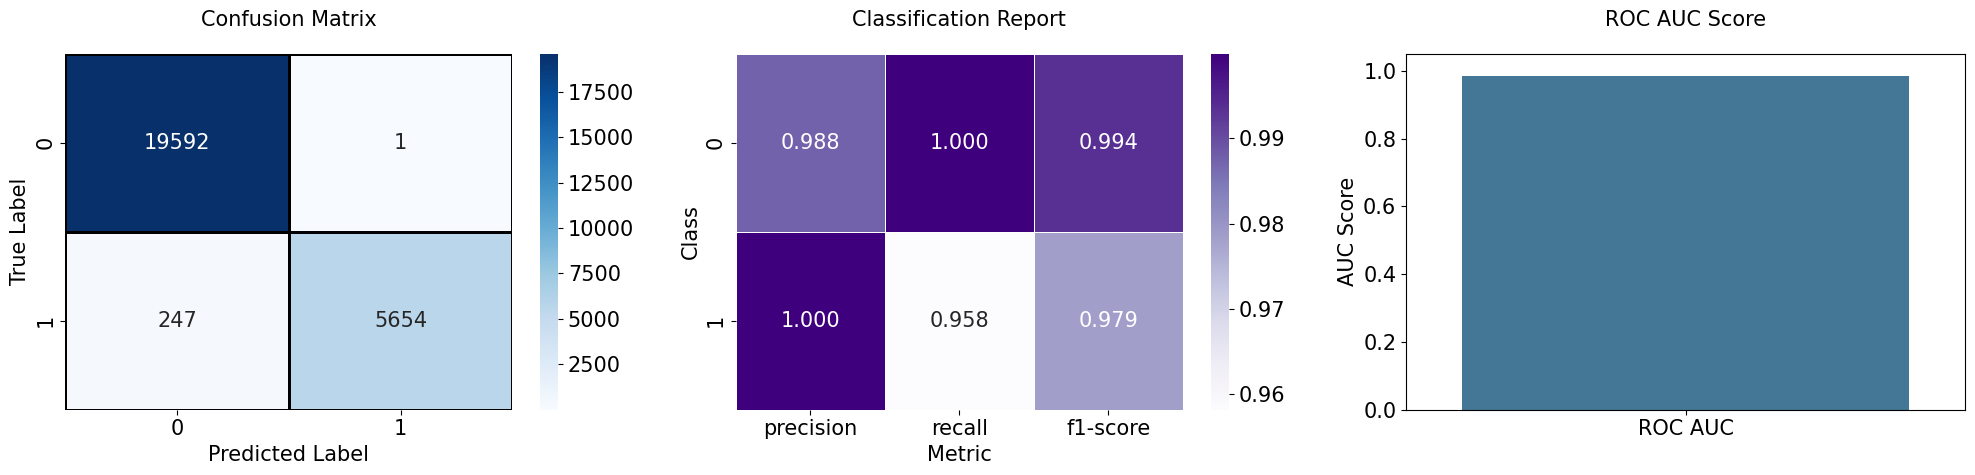

In [59]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration des tailles de police
plt.rcParams.update({
    'axes.titlesize': 15,
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.size': 15
})

# Calcul des métriques
y_test_pred = rf_final.predict(X_test_inter)
y_test_proba = rf_final.predict_proba(X_test_inter)[:, 1]
cm = confusion_matrix(y_test, y_test_pred)
report = classification_report(y_test, y_test_pred, digits=3, output_dict=True)
roc_auc = roc_auc_score(y_test, y_test_proba)

# Conversion du rapport en DataFrame
report_df = pd.DataFrame(report).transpose()

# Création de la figure avec 3 subplots
plt.figure(figsize=(20, 5))

# Subplot 1: Matrice de confusion
plt.subplot(1, 3, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            annot_kws={"size": 15}, linewidths=1, linecolor='black')
plt.title("Confusion Matrix", pad=20)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Subplot 2: Rapport de classification (pour les classes 0 et 1)
plt.subplot(1, 3, 2)
metrics_to_plot = ["precision", "recall", "f1-score"]
sns.heatmap(report_df.loc[['0', '1'], metrics_to_plot],
            annot=True, fmt=".3f", cmap="Purples",
            annot_kws={"size": 15}, linewidths=0.5)
plt.title("Classification Report", pad=20)
plt.xlabel("Metric")
plt.ylabel("Class")

# Subplot 3: Score ROC AUC
plt.subplot(1, 3, 3)
sns.barplot(x=["ROC AUC"], y=[roc_auc], palette="mako")
plt.ylim(0, 1.05)
plt.title("ROC AUC Score", pad=20)
plt.xlabel("")
plt.ylabel("AUC Score")

# Affichage des valeurs numériques dans la console
print(classification_report(y_test, y_test_pred, digits=3))
print("ROC AUC on test:", roc_auc)
print("Confusion Matrix:\n", cm)

plt.tight_layout()
plt.show()

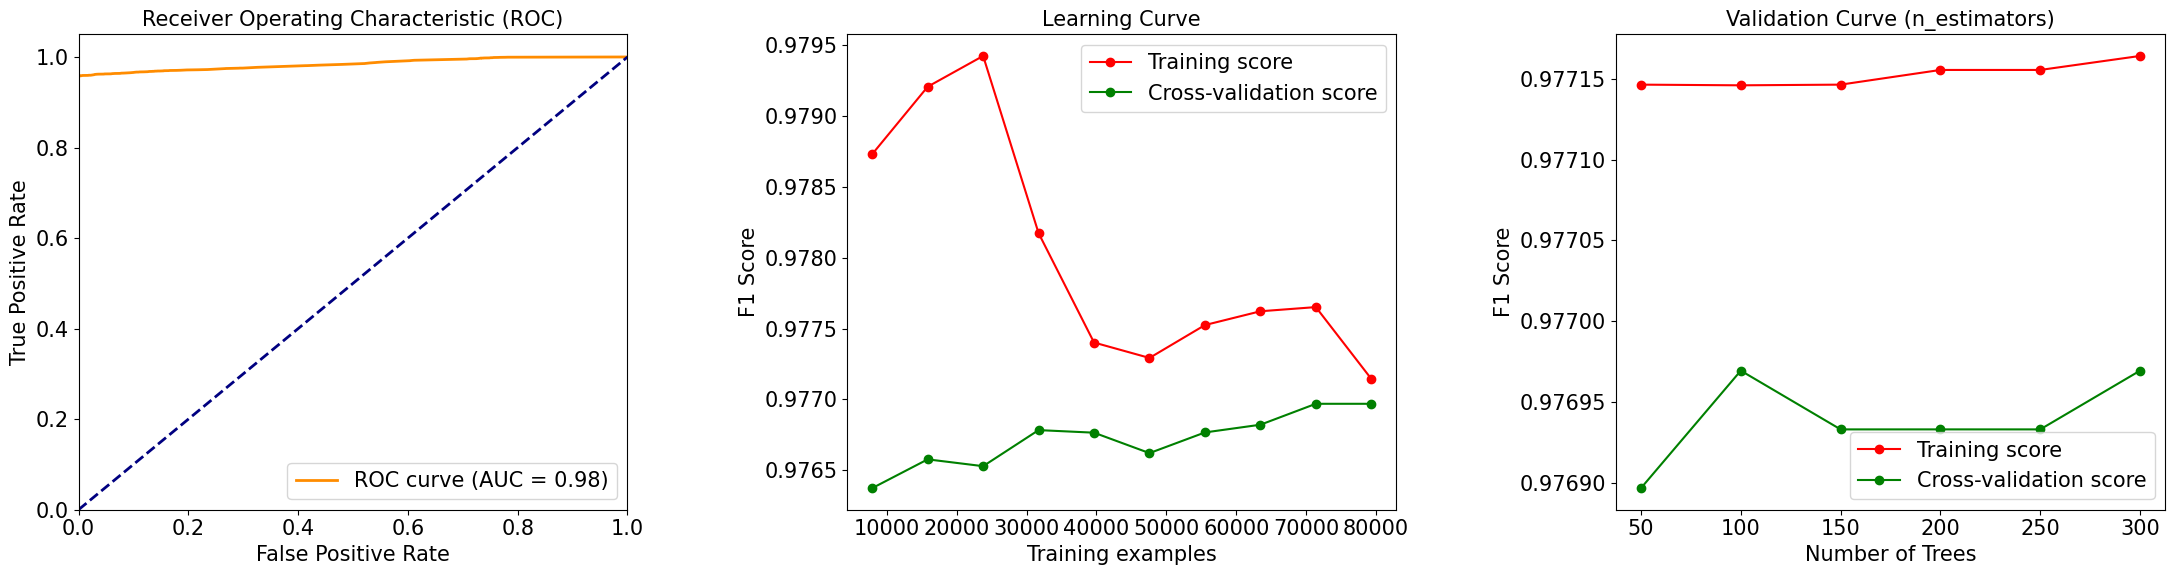

In [60]:
# --- Plot ROC Curve, Learning Curve, and Validation Curve ---
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import learning_curve, validation_curve
import matplotlib.pyplot as plt
import numpy as np

# Configuration des tailles de police
plt.rcParams.update({
    'axes.titlesize': 15,
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 15
})

plt.figure(figsize=(22, 6))

# --------------------------------------
# Subplot 1 : Courbe ROC
# --------------------------------------
plt.subplot(1, 3, 1)

# Ensure y_test_proba is 1D (probability of the positive class)
# This line is crucial to ensure the correct shape
y_test_proba_1d = rf_final.predict_proba(X_test_inter)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_test_proba_1d) # Use the 1D variable here
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")

# --------------------------------------
# Subplot 2 : Courbe d'apprentissage
# --------------------------------------
plt.subplot(1, 3, 2)

# Calcul de la courbe d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    ),
    X_train_inter,
    y_train,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()

# --------------------------------------
# Subplot 3 : Courbe de validation (n_estimators)
# --------------------------------------
plt.subplot(1, 3, 3)

# Paramètre à tester
param_range = [50, 100, 150, 200, 250, 300]

# Calcul de la courbe de validation
train_scores, test_scores = validation_curve(
    RandomForestClassifier(
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        class_weight='balanced'
    ),
    X_train_inter,
    y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="f1",
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Number of Trees")
plt.ylabel("F1 Score")
plt.title("Validation Curve (n_estimators)")
plt.legend()

# Ajustement final
plt.tight_layout(w_pad=4)
plt.show()

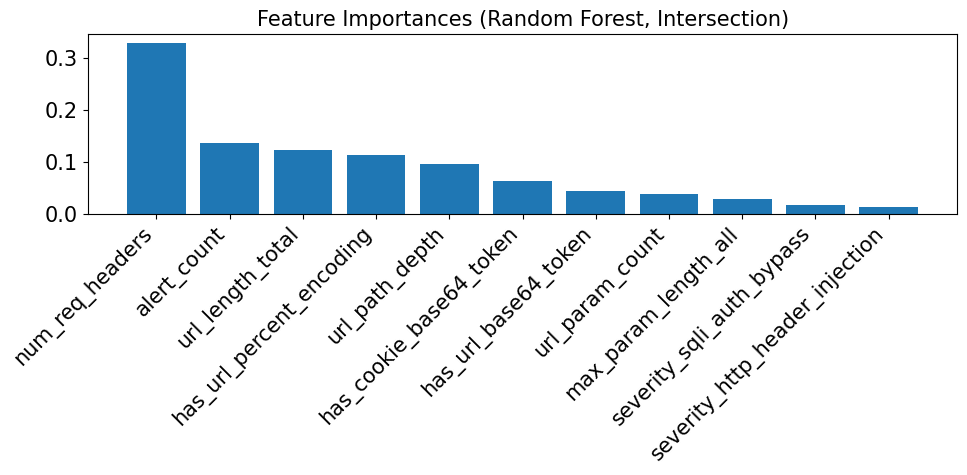

In [61]:
import matplotlib.pyplot as plt
import numpy as np

feat_importances = rf_final.feature_importances_
sorted_idx = np.argsort(feat_importances)[::-1]
plt.figure(figsize=(10, 5))
plt.bar([features_intersection[i] for i in sorted_idx], feat_importances[sorted_idx])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importances (Random Forest, Intersection)')
plt.tight_layout()
plt.show()


In [62]:
import joblib
joblib.dump(rf_final, "/content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Model_Exported/RF_BINARY.joblib")

['/content/drive/MyDrive/BINOME_WORK/PFE_NIT/AI_CODE_DATASETS/STEP_2_AI_Training/Model_Exported/RF_BINARY.joblib']